In [932]:
# Import relevant modules
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
import pybird
from importlib import reload
from copy import deepcopy
from scipy.interpolate import interp1d
import scipy.optimize as op
from scipy import stats
def pvalue(minchi2, dof):
    return 1. - stats.chi2.cdf(minchi2, dof)
from scipy.interpolate import UnivariateSpline

In [873]:
from math import atan2,degrees
import numpy as np

#Label line with line2D label data
def labelLine(line,x,label=None,align=True,**kwargs):

    ax = line.axes
    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if (x < xdata[0]) or (x > xdata[-1]):
        print('x label location is outside data range!')
        return

    #Find corresponding y co-ordinate and angle of the line
    ip = 1
    for i in range(len(xdata)):
        if x < xdata[i]:
            ip = i
            break

    y = ydata[ip-1] + (ydata[ip]-ydata[ip-1])*(x-xdata[ip-1])/(xdata[ip]-xdata[ip-1])

    if not label:
        label = line.get_label()

    if align:
        #Compute the slope
        dx = xdata[ip] - xdata[ip-1]
        dy = ydata[ip] - ydata[ip-1]
        ang = degrees(atan2(dy,dx))

        #Transform to screen co-ordinates
        pt = np.array([x,y]).reshape((1,2))
        trans_angle = ax.transData.transform_angles(np.array((ang,)),pt)[0]

    else:
        trans_angle = 0

    #Set a bunch of keyword arguments
    if 'color' not in kwargs:
        kwargs['color'] = line.get_color()

    if ('horizontalalignment' not in kwargs) and ('ha' not in kwargs):
        kwargs['ha'] = 'center'

    if ('verticalalignment' not in kwargs) and ('va' not in kwargs):
        kwargs['va'] = 'center'

    if 'backgroundcolor' not in kwargs:
        kwargs['backgroundcolor'] = ax.get_facecolor()

    if 'clip_on' not in kwargs:
        kwargs['clip_on'] = True

    if 'zorder' not in kwargs:
        kwargs['zorder'] = 2.5

    t=ax.text(x,y,label,rotation=trans_angle,**kwargs)
    # t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))

def labelLines(lines,align=True,xvals=None,**kwargs):

    ax = lines[0].axes
    labLines = []
    labels = []

    #Take only the lines which have labels other than the default ones
    for line in lines:
        label = line.get_label()
        if "_line" not in label:
            labLines.append(line)
            labels.append(label)

    if xvals is None:
        xmin,xmax = ax.get_xlim()
        xvals = np.linspace(xmin,xmax,len(labLines)+2)[1:-1]

    for line,x,label in zip(labLines,xvals,labels):
        labelLine(line,x,label,align,**kwargs)


In [915]:
font = {'size': 12, 'family': 'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]

In [916]:
zpk = .57
kdata = np.arange(0.01, 0.31, 0.005)
sdata = np.arange(5, 200, 1)

In [917]:
from classy import Class
M = Class()
M.set({'omega_b': 0.02237, 'omega_cdm': 0.120, 'h': 0.6736, 'ln10^{10}A_s': 3.044, 'n_s': 0.9649})
M.set({'output': 'mPk', 'P_k_max_1/Mpc': 1.0, 'z_max_pk': zpk})
M.compute()
f1 = M.scale_independent_growth_factor_f(zpk) # growth rate
kk = np.logspace(-5, 0, 200) # k in h/Mpc
pklin = np.array([M.pk(k*M.h(), zpk)*M.h()**3 for k in kk]) # P(k) in (Mpc/h)**3
ipklin = interp1d(kk, pklin, kind='cubic')
pk11 = ipklin(kdata)
print (f1)

0.7818908365841581


In [1123]:
def extrap(self, xin, f, extrap='extrap', window=1, Nmax=512):
    interpfunc = interp1d(xin, f, kind='cubic')
    fx = np.empty(Nmax)
    tmp = np.empty(int(Nmax / 2 + 1), dtype=complex)
    Coef = np.empty(Nmax + 1, dtype=complex)
    
    if extrap is 'extrap':
        if xin[0] > self.x[0]:
            #print ('low extrapolation')
            nslow = (log(f[1]) - log(f[0])) / (log(xin[1]) - log(xin[0]))
            Aslow = f[0] / xin[0]**nslow
        if xin[-1] < self.x[-1]:
            #print ('high extrapolation')
            nshigh = (log(f[-1]) - log(f[-2])) / (log(xin[-1]) - log(xin[-2]))
            Ashigh = f[-1] / xin[-1]**nshigh

        for i in range(self.Nmax):
            if xin[0] > self.x[i]:
                fx[i] = Aslow * self.x[i]**nslow
            elif xin[-1] < self.x[i]:
                fx[i] = Ashigh * self.x[i]**nshigh
            else:
                fx[i] = interpfunc(self.x[i])

In [1250]:
kplot = np.logspace(-20, 20, 2000) 
# kplot = np.logspace(-5, 0, 200) 

In [1251]:
from fftlog import FFTLog
fftsettings = dict(Nmax=256, xmin=1.5e-5, xmax=1000., bias=-1.6)
fft = FFTLog(**fftsettings)
pfftm1p6 = fft.sumCoefxPow(kk, pklin, kplot, window=0.)

In [1252]:
fftsettings = dict(Nmax=256, xmin=1.5e-5, xmax=1000., bias=-.3)
fft = FFTLog(**fftsettings)
pfftm0p3 = fft.sumCoefxPow(kk, pklin, kplot, window=0.)

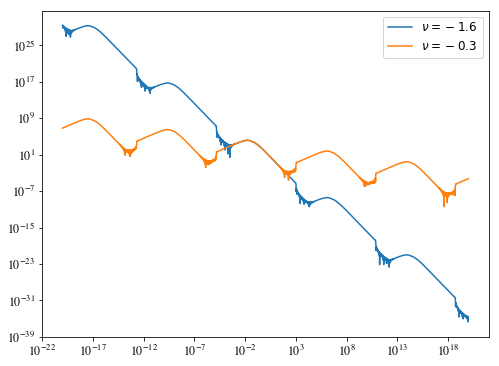

In [1253]:
#plt.plot(kk, pklin)
plt.plot(kplot, np.abs(pfftm1p6*kplot**0), label=r'$\nu=-1.6$')
plt.plot(kplot, np.abs(pfftm0p3*kplot**0), label=r'$\nu=-0.3$')
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [1254]:
np.savetxt("/Users/pierre/Desktop/fftlog_pk.dat", np.vstack([kplot, pfftm1p6, pfftm0p3]).T, header="k,nu=-1.6,nu=-0.3")


(1.7782794100389228e-22, 5.623413251903491e+16)

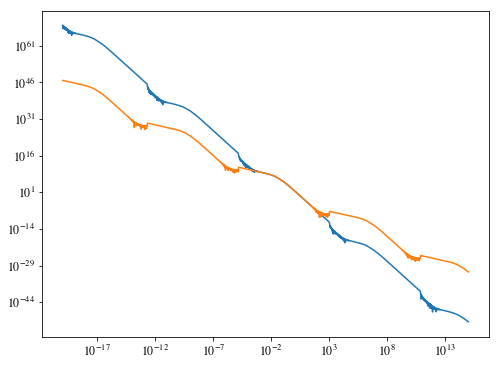

In [1246]:
#plt.plot(kk, pklin/kk**2)
plt.plot(kplot, np.abs(pfftm1p6/kplot**2))
plt.plot(kplot, np.abs(pfftm0p3/kplot**2))
plt.xscale('log')
plt.yscale('log')
plt.xlim()

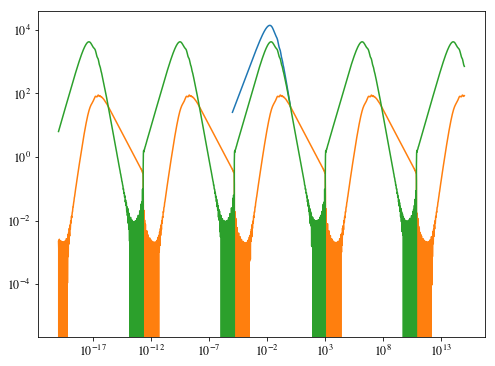

In [1241]:
plt.plot(kk, pklin)
plt.plot(kplot, pfftm1p6/kplot**-1.6)
plt.plot(kplot, pfftm0p3/kplot**-0.3)
plt.xscale('log')
plt.yscale('log')

### Finite UV piece

In [918]:
mu = {
    0: {0: 1., 2: 0., 4: 0.},
    2: {0: 1. / 3., 2: 2. / 3., 4: 0.},
    4: {0: 1. / 5., 2: 4. / 7., 4: 8. / 35.},
    6: {0: 1. / 7., 2: 10. / 21., 4: 24. / 77.},
    8: {0: 1. / 9., 2: 40. / 99., 4: 48. / 148.}
}

In [919]:
sigma_v = np.trapz(pklin, x=kk)
sigma_r = np.trapz(pklin[:-25], x=kk[:-25])
print (sigma_v, sigma_r)

1117.3484384669769 973.6320061259556


In [920]:
sigma_v = np.trapz(pklin, x=kk)

def uv_finite_cct(b1, b3, f1): 
    return (3*b1 - 64*b3)/1260. * sigma_v/np.pi**2
def uv_finite_cr1(b1, b3, f1): 
    return -(f1*(63 + 48*f1 + b1*(-2 + 35*f1)))/420. * sigma_v/np.pi**2
def uv_finite_cr2(b1, b3, f1):  
    return -(f1**2*(46 + 35*f1))/420. * sigma_v/np.pi**2
def uv_finite_p13(b1, b3, f1):
    b5, b6, b7 = uv_finite_cct(b1, b3, f1), uv_finite_cr1(b1, b3, f1), uv_finite_cr2(b1, b3, f1)
    return np.array([(2. * b1 * (b5 * mu[0][l] + b6 * mu[2][l] + b7 * mu[4][l]) + 2. * f1 * (b5 * mu[2][l] + b6 * mu[4][l] + b7 * mu[6][l])) * kdata**2 * pk11  for l in [0, 2, 4]])
def uv_finite_dm_easy():
    return uv_finite_cct(1, 1, 0)
# print (uv_finite_dm_easy()*0.7**2)

In [921]:
# \Delta cct: ((3*b1 - 64*b3p)*IntdqP11*kM**2)/(1260.*Pi**2)
# \Delta cr1: -(f1*(63 + 48*f1 + b1*(-2 + 35*f1))*IntdqP11*kr**2)/(420.*Pi**2)
# \Delta cr2: -(f1**2*(46 + 35*f1)*IntdqP11*kr**2)/(420.*Pi**2)

In [922]:
cct = 0.7**2 * uv_finite_cct(1.901, -0.9743, f1)
cr1 = 0.7**2 * uv_finite_cr1(1.901, -0.9743, f1)
print (cct, cr1)

2.996366097765773 -15.361874729208933


### dark matter

In [923]:
pieces = ["full", "sptloop", "sptloop22", "sptloop13"]

In [924]:
reload(pybird)
ct = {'cct': 0.}
N = pybird.Correlator()
N.set({'output': 'mPk', 'multipole': 0, 'xdata': kdata, 'resum': False, 
       'keep_loop_pieces_independent': True, 'fftbias': -1.6})
N.compute({'k11': kk, 'P11': pklin})
pkm1p6 = []
for what in pieces: pkm1p6.append( N.get(ct, what=what) )

N = pybird.Correlator()
N.set({'output': 'mPk', 'multipole': 0, 'xdata': kdata, 'resum': False, 
       'keep_loop_pieces_independent': True, 'fftbias': -0.3})
N.compute({'k11': kk, 'P11': pklin})
pkm0p3 = []
for what in pieces: pkm0p3.append( N.get(ct, what=what) )

-1.6
-0.3


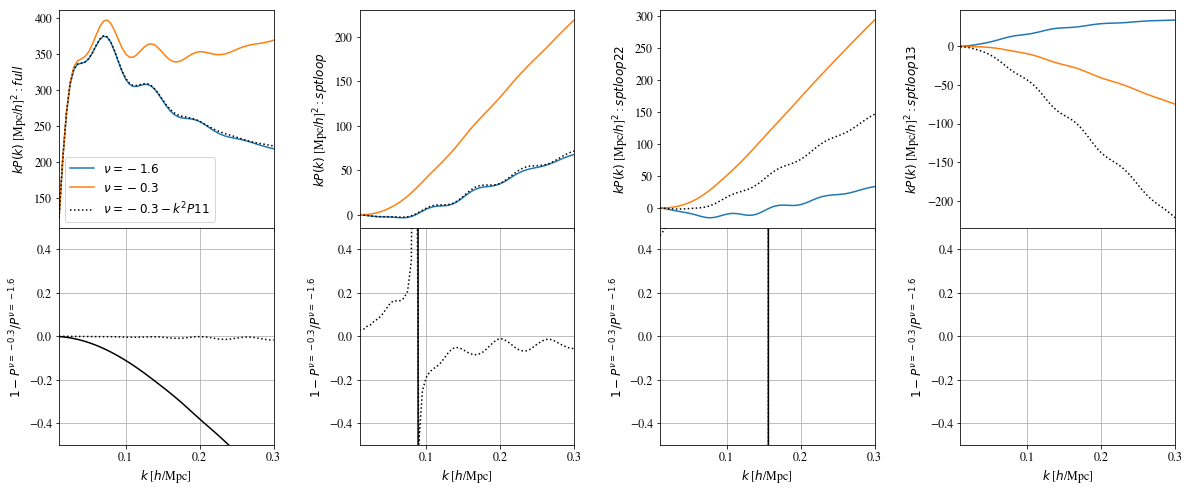

In [925]:
f, ax = plt.subplots(2, 4, figsize=(20,8), sharey=False, sharex=True)
plt.subplots_adjust(wspace=.4, hspace=0)

uv_finite_dm =  uv_finite_p13(1, 1, 0)[0] 

for i, what in enumerate(pieces):
    ax[0,i].plot(kdata, kdata*pkm1p6[i][0], label=r'$\nu=-1.6$')
    ax[0,i].plot(kdata, kdata*pkm0p3[i][0], label=r'$\nu=-0.3$')
    ax[0,i].plot(kdata, kdata*(pkm0p3[i][0] + uv_finite_dm), 'k:', label=r'$\nu=-0.3 - k^2 P11$')
    ax[0,i].set_xlim(0.01, 0.3)
    ax[0,i].set_xlabel(r'$k$ [$h$/Mpc]')
    ax[0,i].set_ylabel(r'$k P(k)$ [Mpc/$h$]$^{2} : %s$' % what)

    ax[1,i].plot(kdata, 1-pkm0p3[i][0]/pkm1p6[i][0], 'k')
    ax[1,i].plot(kdata, 1-(pkm0p3[i][0] + uv_finite_dm)/pkm1p6[i][0], 'k:')
    ax[1,i].set_xlim(0.01, 0.3)
    ax[1,i].set_xlabel(r'$k$ [$h$/Mpc]')
    ax[1,i].set_ylabel(r'$1-P^{\nu=-0.3}/P^{\nu=-1.6}$')
    ax[1,i].set_ylim(-0.5, 0.5)
    ax[1,i].grid()

ax[0,0].legend()

### dark matter for various fftbias

In [710]:
manyfftbias = [-0.51, -0.9, -0.99, -1.01, -1.10, -1.49]#[-0.01, -0.49, -0.51, 0.75, -0.99, -1.01, -1.49, -1.51, -1.99, -2.01]
manypkm = []
for fftbias in manyfftbias: 
    ct = {'cct': 0.}
    N = pybird.Correlator()
    N.set({'output': 'mPk', 'multipole': 0, 'xdata': kdata, 'resum': False, 
           'keep_loop_pieces_independent': True, 'fftbias': fftbias})
    N.compute({'k11': kk, 'P11': pklin})
    pkm = []
    for what in pieces: pkm.append( N.get(ct, what=what) )
    manypkm.append(np.array(pkm))
manypkm = np.array(manypkm)

-0.51
-0.9
-0.99
-1.01
-1.1
-1.49


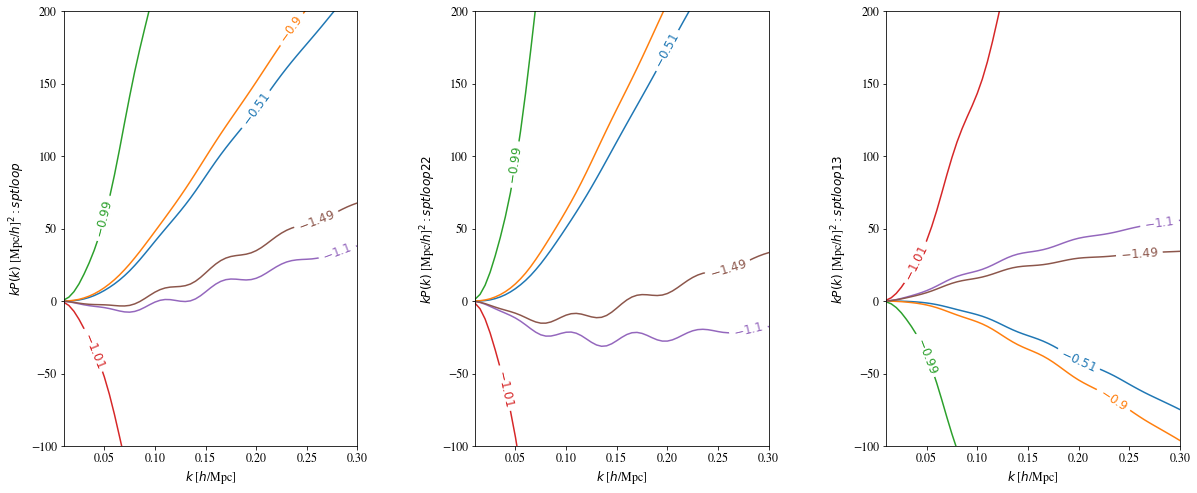

In [714]:
f, ax = plt.subplots(1, 3, figsize=(20,8), sharey=False, sharex=True)
plt.subplots_adjust(wspace=.4, hspace=0)

uv_finite_dm =  uv_finite_p13(1, 1, 0)[0] 

for n, (fftbias, pkm) in enumerate(zip(manyfftbias, manypkm)):
    #if n % 2 != 0:
    #if n >= 2 and n <=5:
    #if n <=6:
    #if n >= 6:
    if True:
        for i, what in enumerate(pieces[1:]):
            ax[i].plot(kdata, kdata*pkm[i+1][0], label=r'$%s$' % (fftbias))
            #ax[0,i].plot(kdata, kdata*(pkm0p3[i][0] + uv_finite_dm), 'k:', label=r'$\nu=-0.3 - k^2 P11$')
            ax[i].set_xlim(0.01, 0.3)
            ax[i].set_ylim(-100, 200)
            ax[i].set_xlabel(r'$k$ [$h$/Mpc]')
            ax[i].set_ylabel(r'$k P(k)$ [Mpc/$h$]$^{2} : %s$' % what)

for i, what in enumerate(pieces[1:]):
    labelLines(ax[i].get_lines(), xvals=[0.2, 0.235, 0.05, 0.04, 0.28, 0.26])
            
#ax[0].legend()

Text(0.15, 180, '$-1<\\nu<-1.5$')

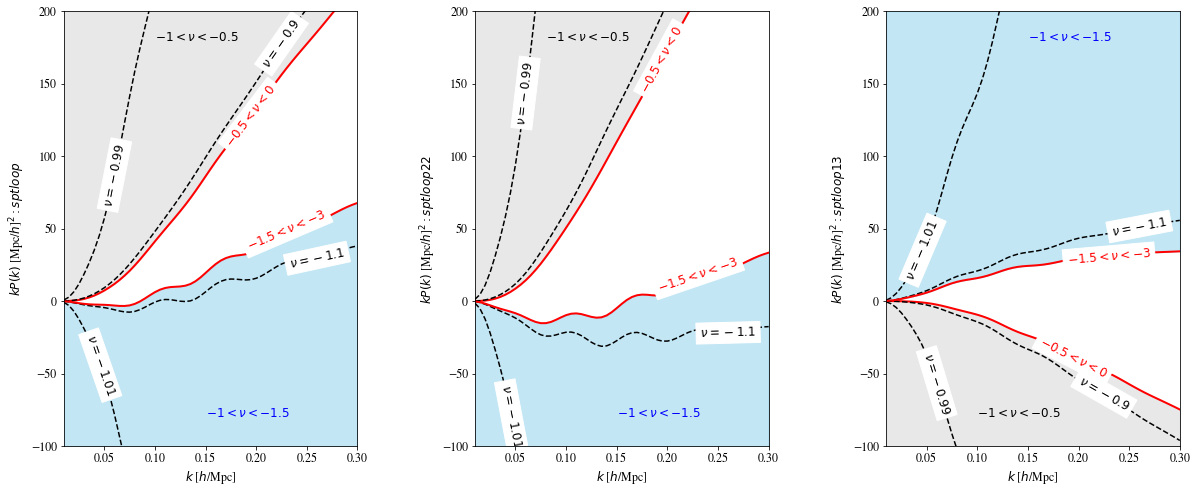

In [771]:
f, ax = plt.subplots(1, 3, figsize=(20,8), sharey=False, sharex=True)
plt.subplots_adjust(wspace=.4, hspace=0)

uv_finite_dm =  uv_finite_p13(1, 1, 0)[0] 

for n, (fftbias, pkm) in enumerate(zip(manyfftbias, manypkm)):
    for i, what in enumerate(pieces[1:]):
        if fftbias == -0.51:
            ax[i].plot(kdata, kdata*pkm[i+1][0], 'r', lw=2, label=r'$-0.5<\nu<0$')
        elif fftbias == -1.49:
            ax[i].plot(kdata, kdata*pkm[i+1][0], 'r', lw=2, label=r'$-1.5<\nu<-3$')
        else:
            ax[i].plot(kdata, kdata*pkm[i+1][0], 'k--', label=r'$\nu = %s$' % (fftbias))
        #ax[0,i].plot(kdata, kdata*(pkm0p3[i][0] + uv_finite_dm), 'k:', label=r'$\nu=-0.3 - k^2 P11$')
        ax[i].set_xlim(0.01, 0.3)
        ax[i].set_ylim(-100, 200)
        ax[i].set_xlabel(r'$k$ [$h$/Mpc]')
        ax[i].set_ylabel(r'$k P(k)$ [Mpc/$h$]$^{2} : %s$' % what)
        
for i, what in enumerate(pieces[1:]):
    labelLines(ax[i].get_lines(), xvals=[0.195, 0.225, 0.06, 0.046, 0.26, 0.23])
    
ax[0].fill_between(kdata, 200., kdata*manypkm[0][1][0], alpha=0.5, color='lightgray')
ax[1].fill_between(kdata, 200., kdata*manypkm[0][2][0], alpha=0.5, color='lightgray')
ax[2].fill_between(kdata, -200., kdata*manypkm[0][3][0], alpha=0.5, color='lightgray')

ax[0].fill_between(kdata, -200., kdata*manypkm[-1][1][0], alpha=0.5, color='skyblue')
ax[1].fill_between(kdata, -200., kdata*manypkm[-1][2][0], alpha=0.5, color='skyblue')
ax[2].fill_between(kdata, 200., kdata*manypkm[-1][3][0], alpha=0.5, color='skyblue')

ax[0].text(0.1, 180, r"$-1<\nu<-0.5$")
ax[0].text(0.15, -80, r"$-1<\nu<-1.5$", color='blue')

ax[1].text(0.08, 180, r"$-1<\nu<-0.5$")
ax[1].text(0.15, -80, r"$-1<\nu<-1.5$", color='blue')

ax[2].text(0.1, -80, r"$-1<\nu<-0.5$")
ax[2].text(0.15, 180, r"$-1<\nu<-1.5$", color='blue')

#ax[0].legend()

### dark matter in redshift space

numerical

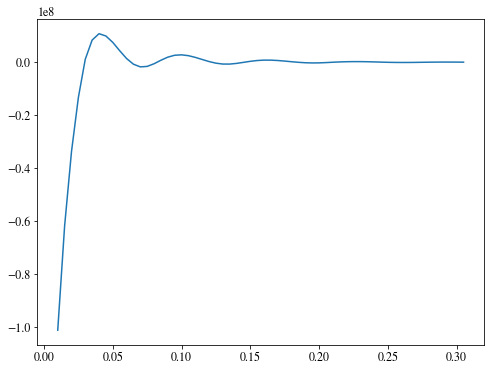

In [1065]:
# ipklin = interp1d(kk, pklin, kind='cubic', bounds_error=False, fill_value=0.)
ipklin = UnivariateSpline(kk, pklin, k=5, s=0)
#plt.plot(kdata, ipklin.derivative()(kdata))
plt.plot(kdata, ipklin.derivative().derivative()(kdata))

In [1002]:
from cubature import cubature
def P22int(kk, qq, x):
    K2int = (kk**4*(kk*qq*x*(12.238299066500128 - 51.078674225887184*x**2) + kk**2*(0.46498219117976763 + 18.955205388513757*x**2) + qq**2*(2.57736542573823 - 17.393029917976584*x**2 + 34.23585207193189*x**4)))/(2.*qq**2*(kk**2 + qq**2 - 2.*kk*qq*x)**2)
    return K2int * ipklin(qq) * ipklin(np.sqrt(kk**2 + qq**2 - 2 * kk * qq * x))

P22 = []
for k in kdata:
    def integrand(x_array):
        return P22int(k, np.array(x_array[:, 0]), np.array(x_array[:, 1]))
    val, err = cubature(integrand, 2, 1, [1.5e-5, 1], [-1, 1], vectorized=True)
    P22.append(err)
P22 = np.array(P22)


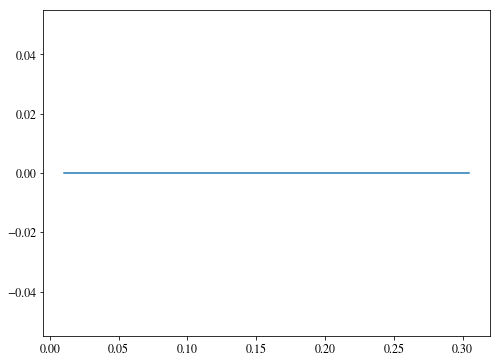

In [1003]:
plt.plot(kdata, kdata*P22Int[:,0])

In [1006]:
path = os.path.join("/", "Users", "pierre", "Documents", "github", "montepython_public-3.3", "bisp", "tmp", "0215") 
knum, mononump13 = np.loadtxt(os.path.join(path, "P13MonoDM.dat"), unpack=True)
knum, quadnump13 = np.loadtxt(os.path.join(path, "P13QuadDM.dat"), unpack=True)
knum, mononump22 = np.loadtxt(os.path.join(path, "P22MonoDM.dat"), unpack=True)
knum, quadnump22 = np.loadtxt(os.path.join(path, "P22QuadDM.dat"), unpack=True)

In [941]:
reload(pybird)
ct = {'cct': 1.2, 'cr1': -1.6}
N = pybird.Correlator()
N.set({'output': 'mPk', 'multipole': 2, 'xdata': kdata, 'resum': False, 'fftbias': -1.6,
       'keep_loop_pieces_independent': True, 'fftbias': -1.6})
N.compute({'k11': kk, 'P11': pklin, 'f': f1})
pkm1p6 = []
for what in pieces: pkm1p6.append( N.get(ct, what=what) )

N = pybird.Correlator()
N.set({'output': 'mPk', 'multipole': 2, 'xdata': kdata, 'resum': False, 'fftbias': -0.3,
       'keep_loop_pieces_independent': True, 'fftbias': -0.3})
N.compute({'k11': kk, 'P11': pklin, 'f': f1})
pkm0p3 = []
for what in pieces: pkm0p3.append( N.get(ct, what=what) )

-1.6
-0.3


In [942]:
sigma_v = np.trapz(pklin, x=kk)

def uv_finite_p13_pierre(b1, b3, f1):
    return 4*np.pi / (2*np.pi)**3 * np.array([  (b1**2/105. - (64*b1*b3)/315.)*mu[0][l]
                     + ((-186*b1*f1 + 6*b1**2*f1 - 64*b3*f1 - 144*b1*f1**2 - 105*b1**2*f1**2)*mu[2][l])/315. 
                     + ((-63*f1**2 - 44*b1*f1**2 - 48*f1**3 - 70*b1*f1**3)*mu[4][l])/105. 
                     + ((-46*f1**3)/105. - f1**4/3.)*mu[6][l] for l in [0,2,4] ])

def uv_finite_p22k2_pierre(b1, b2, b4, f1):
     return 4*np.pi / (2*np.pi)**3 * 0.1836734693877551 + (36*f1*\[Mu]**2)/49. + (6*f1**2*\[Mu]**2)/35. + (208*f1**2*\[Mu]**4)/245. + (12*f1**3*\[Mu]**4)/35. + (f1**4*\[Mu]**4)/5. + (8*f1**3*\[Mu]**6)/35.
    
    

In [955]:
uv_finite_p13_pierre(1, 1, f1)[0]*sigma_v

-47.34345826420004

In [956]:
uv_finite_p13_pierre(1, 1, f1)[1]*sigma_v

-87.6229592584794

In [943]:
print ( (uv_finite_p13(1, 1, f1)[0] / (kdata**2*pk11*sigma_v) )[0] / uv_finite_p13_pierre(1, 1, f1)[0] )
print ( (uv_finite_p13(1, 1, f1)[1] / (kdata**2*pk11*sigma_v) )[0] / uv_finite_p13_pierre(1, 1, f1)[1] )

0.9999999999999999
0.9999999999999998


monopole

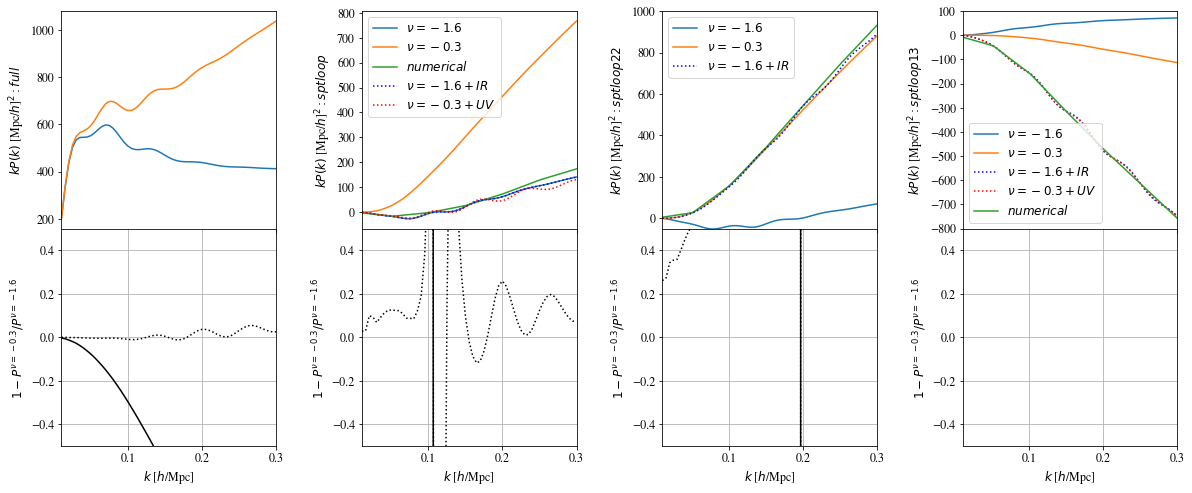

In [1099]:
f, ax = plt.subplots(2, 4, figsize=(20,8), sharey=False, sharex=True)
plt.subplots_adjust(wspace=.4, hspace=0)

uv_finite_dm_13_mono =  uv_finite_p13_pierre(1, 1, f1)[0] * sigma_v * kdata**2 * pk11
ir_finite_dm_13_mono = -61.0738 * kdata**2 * pk11 

ir_finite_dm_22_mono = 2 * 30.5369 * kdata**2 * pk11 #+ 0.1 * pk11

for i, what in enumerate(pieces):
    ax[0,i].plot(kdata, kdata*pkm1p6[i][0], label=r'$\nu=-1.6$')
    ax[0,i].plot(kdata, kdata*pkm0p3[i][0], label=r'$\nu=-0.3$')
    ax[0,i].set_xlim(0.01, 0.3)
    ax[0,i].set_xlabel(r'$k$ [$h$/Mpc]')
    ax[0,i].set_ylabel(r'$k P(k)$ [Mpc/$h$]$^{2} : %s$' % what)
    
    ax[1,i].plot(kdata, 1-pkm0p3[i][0]/pkm1p6[i][0], 'k')
    ax[1,i].plot(kdata, 1-(pkm0p3[i][0] + uv_finite_dm)/pkm1p6[i][0], 'k:')
    ax[1,i].set_xlim(0.01, 0.3)
    ax[1,i].set_xlabel(r'$k$ [$h$/Mpc]')
    ax[1,i].set_ylabel(r'$1-P^{\nu=-0.3}/P^{\nu=-1.6}$')
    ax[1,i].set_ylim(-0.5, 0.5)
    ax[1,i].grid()

    
ax[0,1].plot(knum, knum*(mononump22+mononump13), label=r'$numerical$')
ax[0,1].plot(kdata, kdata*(pkm1p6[1][0] + ir_finite_dm_22_mono + ir_finite_dm_13_mono), 'b:', label=r'$\nu=-1.6 + IR$')
ax[0,1].plot(kdata, kdata*(pkm0p3[1][0] + uv_finite_dm_13_mono), 'r:', label=r'$\nu=-0.3 + UV$')
ax[0,1].legend()


ax[0,2].plot(knum, knum*mononump22)
ax[0,2].plot(kdata, kdata*(pkm1p6[2][0] + ir_finite_dm_22_mono), 'b:', label=r'$\nu=-1.6 + IR$')
#ax[0,2].plot(kdata, kdata*(pkm0p3[i][1] + uv_finite_dm_22_mono), 'r:', label=r'$\nu=-0.3 + UV$')
#ax[0,2].plot(kdata, kdata*(pkm0p3[i][1] + uv_finite_dm_22_mono - ir_finite_dm_22_mono), 'k:', label=r'$\nu=-0.3 + UV - IR$')
ax[0,2].set_ylim(-50, 1000)
ax[0,2].legend()

ax[0,3].plot(kdata, kdata*(pkm1p6[3][0] + ir_finite_dm_13_mono), 'b:', label=r'$\nu=-1.6 + IR$')
ax[0,3].plot(kdata, kdata*(pkm0p3[3][0] + uv_finite_dm_13_mono), 'r:', label=r'$\nu=-0.3 + UV$')
# ax[0,3].plot(kdata, kdata*(pkm0p3[3][0] + uv_finite_dm_13_mono - ir_finite_dm_13_mono), 'k:', label=r'$\nu=-0.3 + UV - IR$')
ax[0,3].plot(knum, knum*mononump13, label='$numerical$')

ax[0,3].set_ylim(-800, 100)
ax[0,3].legend()


quadrupole

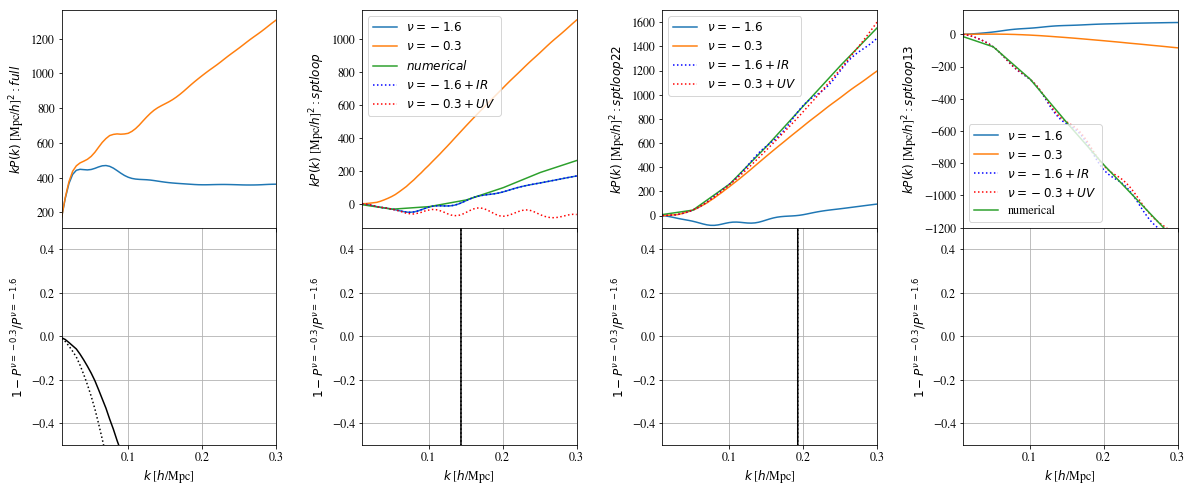

In [1120]:
f, ax = plt.subplots(2, 4, figsize=(20,8), sharey=False, sharex=True)
plt.subplots_adjust(wspace=.4, hspace=0)

uv_finite_dm_13_quad =  uv_finite_p13_pierre(1, 1, f1)[1] * sigma_v * kdata**2 * pk11
ir_finite_dm_13_quad = -102.182 * kdata**2 * pk11 

ir_finite_dm_22_quad = 2 * 51.091 * kdata**2 * pk11 
uv_finite_dm_22_quad = 15000*kdata**2 # 20 * kdata**2 * pk11 #

for i, what in enumerate(pieces):
    ax[0,i].plot(kdata, kdata*pkm1p6[i][1], label=r'$\nu=-1.6$')
    ax[0,i].plot(kdata, kdata*pkm0p3[i][1], label=r'$\nu=-0.3$')
    ax[0,i].set_xlim(0.01, 0.3)
    ax[0,i].set_xlabel(r'$k$ [$h$/Mpc]')
    ax[0,i].set_ylabel(r'$k P(k)$ [Mpc/$h$]$^{2} : %s$' % what)

    ax[1,i].plot(kdata, 1-pkm0p3[i][1]/pkm1p6[i][1], 'k')
    #ax[1,i].plot(kdata, 1-(pkm0p3[i][1] + uv_finite_dm)/pkm1p6[i][1], 'k:')
    ax[1,i].plot(kdata, 1-(pkm0p3[i][1] + uv_finite_dm - ir_finite_dm_quad)/pkm1p6[i][1], 'k:')
    ax[1,i].set_xlim(0.01, 0.3)
    ax[1,i].set_xlabel(r'$k$ [$h$/Mpc]')
    ax[1,i].set_ylabel(r'$1-P^{\nu=-0.3}/P^{\nu=-1.6}$')
    ax[1,i].set_ylim(-0.5, 0.5)
    ax[1,i].grid()    

ax[0,1].plot(knum, knum*(quadnump22+quadnump13), label=r'$numerical$')
ax[0,1].plot(kdata, kdata*(pkm1p6[1][1] + ir_finite_dm_22_quad + ir_finite_dm_13_quad), 'b:', label=r'$\nu=-1.6 + IR$')
ax[0,1].plot(kdata, kdata*(pkm0p3[1][1] + uv_finite_dm_13_quad), 'r:', label=r'$\nu=-0.3 + UV$')
ax[0,1].legend()

ax[0,2].plot(knum, knum*quadnump22)
ax[0,2].plot(kdata, kdata*(pkm1p6[2][1] + ir_finite_dm_22_quad), 'b:', label=r'$\nu=-1.6 + IR$')
ax[0,2].plot(kdata, kdata*(pkm0p3[2][1] + uv_finite_dm_22_quad), 'r:', label=r'$\nu=-0.3 + UV$')
# ax[0,2].plot(kdata, kdata*(pkm0p3[i][1] + uv_finite_dm_22_quad - ir_finite_dm_22_quad), 'k:', label=r'$\nu=-0.3 + UV - IR$')
ax[0,2].set_ylim(-100, 1700)
ax[0,2].legend()

ax[0,3].plot(kdata, kdata*(pkm1p6[3][1] + ir_finite_dm_13_quad), 'b:', label=r'$\nu=-1.6 + IR$')
ax[0,3].plot(kdata, kdata*(pkm0p3[3][1] + uv_finite_dm_13_quad), 'r:', label=r'$\nu=-0.3 + UV$')
#ax[0,3].plot(kdata, kdata*(pkm0p3[3][1] + uv_finite_dm_13_quad - ir_finite_dm_13_quad), 'k:', label=r'$\nu=-0.3 + UV - IR$')
ax[0,3].plot(knum, knum*quadnump13, label='numerical')

ax[0,3].set_ylim(-1200, 150)
ax[0,3].legend()


### dark matter in redshift space with various fftbias

In [811]:
manyfftbias = [-0.51, -0.9, -0.99, -1.01, -1.10, -1.49]
manypkm = []
for fftbias in manyfftbias: 
    ct = {'cct': 0., 'cr1': 0}
    N = pybird.Correlator()
    N.set({'output': 'mPk', 'multipole': 2, 'xdata': kdata, 'resum': False, 
           'keep_loop_pieces_independent': True, 'fftbias': fftbias})
    N.compute({'k11': kk, 'P11': pklin, 'f': f1})
    pkm = []
    for what in pieces: pkm.append( N.get(ct, what=what) )
    manypkm.append(np.array(pkm))
manypkm = np.array(manypkm)

-0.51
-0.9
-0.99
-1.01
-1.1
-1.49


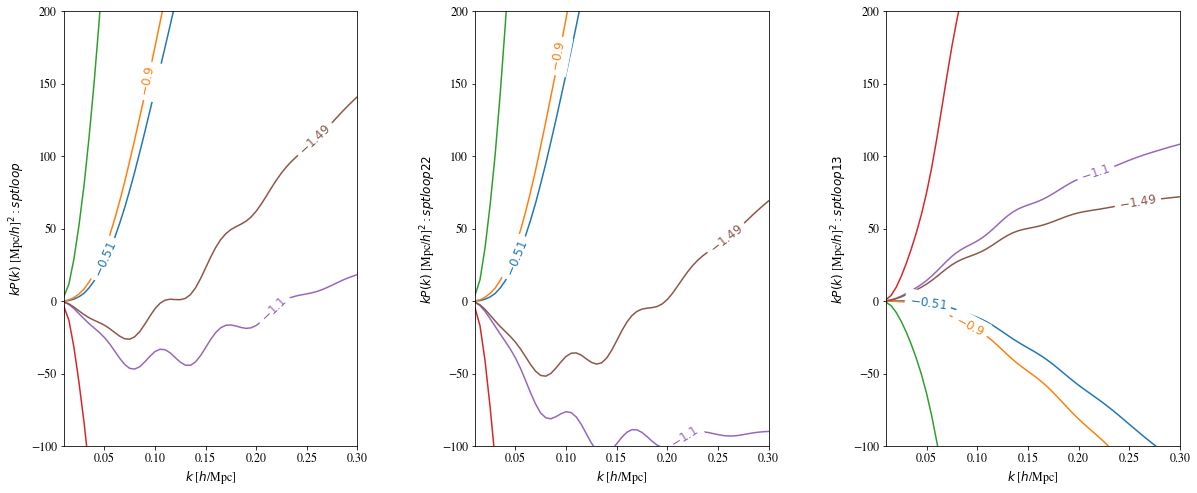

In [812]:
f, ax = plt.subplots(1, 3, figsize=(20,8), sharey=False, sharex=True)
plt.subplots_adjust(wspace=.4, hspace=0)

uv_finite_dm =  uv_finite_p13(1, 1, 0)[0] 

for n, (fftbias, pkm) in enumerate(zip(manyfftbias, manypkm)):
    
        for i, what in enumerate(pieces[1:]):
            ax[i].plot(kdata, kdata*pkm[i+1][0], label=r'$%s$' % (fftbias))
            #ax[0,i].plot(kdata, kdata*(pkm0p3[i][0] + uv_finite_dm), 'k:', label=r'$\nu=-0.3 - k^2 P11$')
            ax[i].set_xlim(0.01, 0.3)
            ax[i].set_ylim(-100, 200)
            ax[i].set_xlabel(r'$k$ [$h$/Mpc]')
            ax[i].set_ylabel(r'$k P(k)$ [Mpc/$h$]$^{2} : %s$' % what)

for i, what in enumerate(pieces[1:]):
    labelLines(ax[i].get_lines())
            
#ax[0].legend()

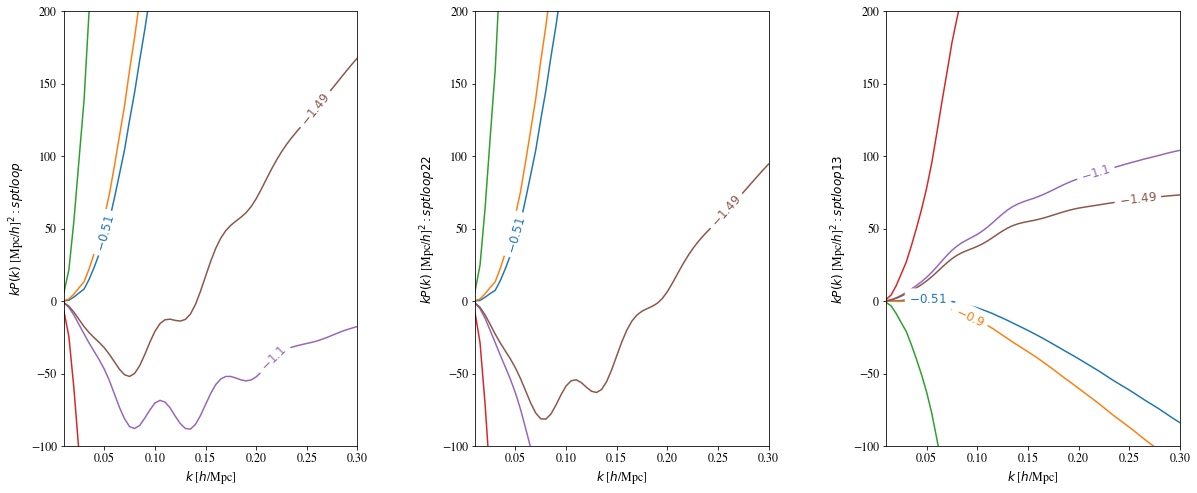

In [813]:
f, ax = plt.subplots(1, 3, figsize=(20,8), sharey=False, sharex=True)
plt.subplots_adjust(wspace=.4, hspace=0)

uv_finite_dm =  uv_finite_p13(1, 1, 0)[1] 

for n, (fftbias, pkm) in enumerate(zip(manyfftbias, manypkm)):
    
        for i, what in enumerate(pieces[1:]):
            ax[i].plot(kdata, kdata*pkm[i+1][1], label=r'$%s$' % (fftbias))
            #ax[0,i].plot(kdata, kdata*(pkm0p3[i][0] + uv_finite_dm), 'k:', label=r'$\nu=-0.3 - k^2 P11$')
            ax[i].set_xlim(0.01, 0.3)
            ax[i].set_ylim(-100, 200)
            ax[i].set_xlabel(r'$k$ [$h$/Mpc]')
            ax[i].set_ylabel(r'$k P(k)$ [Mpc/$h$]$^{2} : %s$' % what)

for i, what in enumerate(pieces[1:]):
    labelLines(ax[i].get_lines())
            
#ax[0].legend()

Text(0.15, 180, '$-1<\\nu<-1.5$')

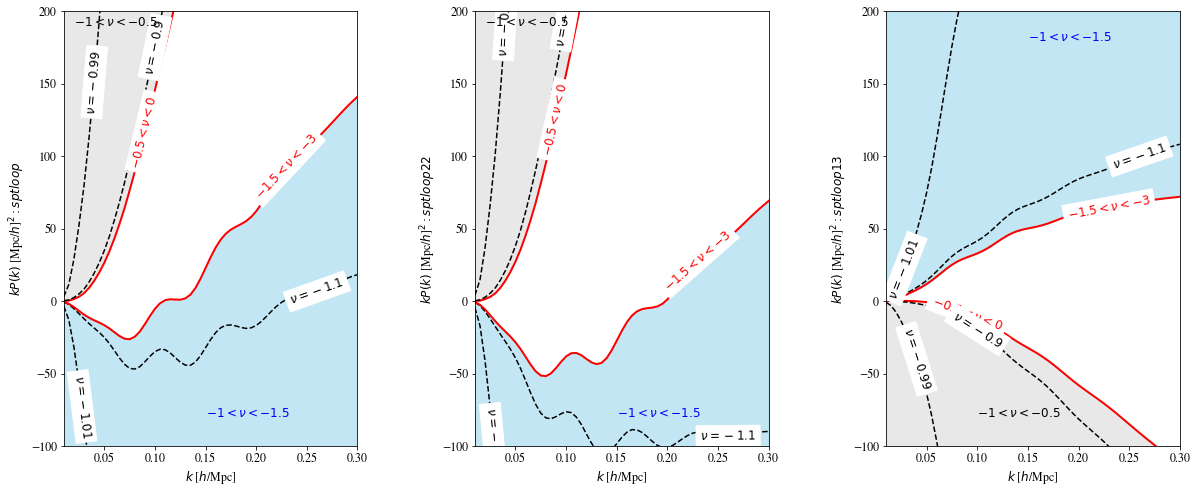

In [833]:
f, ax = plt.subplots(1, 3, figsize=(20,8), sharey=False, sharex=True)
plt.subplots_adjust(wspace=.4, hspace=0)

uv_finite_dm =  uv_finite_p13(1, 1, 0)[0] 

for n, (fftbias, pkm) in enumerate(zip(manyfftbias, manypkm)):
    for i, what in enumerate(pieces[1:]):
        if fftbias == -0.51:
            ax[i].plot(kdata, kdata*pkm[i+1][0], 'r', lw=2, label=r'$-0.5<\nu<0$')
        elif fftbias == -1.49:
            ax[i].plot(kdata, kdata*pkm[i+1][0], 'r', lw=2, label=r'$-1.5<\nu<-3$')
        else:
            ax[i].plot(kdata, kdata*pkm[i+1][0], 'k--', label=r'$\nu = %s$' % (fftbias))
        #ax[0,i].plot(kdata, kdata*(pkm0p3[i][0] + uv_finite_dm), 'k:', label=r'$\nu=-0.3 - k^2 P11$')
        ax[i].set_xlim(0.01, 0.3)
        ax[i].set_ylim(-100, 200)
        ax[i].set_xlabel(r'$k$ [$h$/Mpc]')
        ax[i].set_ylabel(r'$k P(k)$ [Mpc/$h$]$^{2} : %s$' % what)
        
for i, what in enumerate(pieces[1:]):
    labelLines(ax[i].get_lines(), xvals=[0.09, 0.10, 0.04, 0.028, 0.26, 0.23])
    
ax[0].fill_between(kdata, 200., kdata*manypkm[0][1][0], alpha=0.5, color='lightgray')
ax[1].fill_between(kdata, 200., kdata*manypkm[0][2][0], alpha=0.5, color='lightgray')
ax[2].fill_between(kdata, -200., kdata*manypkm[0][3][0], alpha=0.5, color='lightgray')

ax[0].fill_between(kdata, -200., kdata*manypkm[-1][1][0], alpha=0.5, color='skyblue')
ax[1].fill_between(kdata, -200., kdata*manypkm[-1][2][0], alpha=0.5, color='skyblue')
ax[2].fill_between(kdata, 200., kdata*manypkm[-1][3][0], alpha=0.5, color='skyblue')

ax[0].text(0.02, 190, r"$-1<\nu<-0.5$")
ax[0].text(0.15, -80, r"$-1<\nu<-1.5$", color='blue')

ax[1].text(0.02, 190, r"$-1<\nu<-0.5$")
ax[1].text(0.15, -80, r"$-1<\nu<-1.5$", color='blue')

ax[2].text(0.1, -80, r"$-1<\nu<-0.5$")
ax[2].text(0.15, 180, r"$-1<\nu<-1.5$", color='blue')

#ax[0].legend()

Text(0.15, 180, '$-1<\\nu<-1.5$')

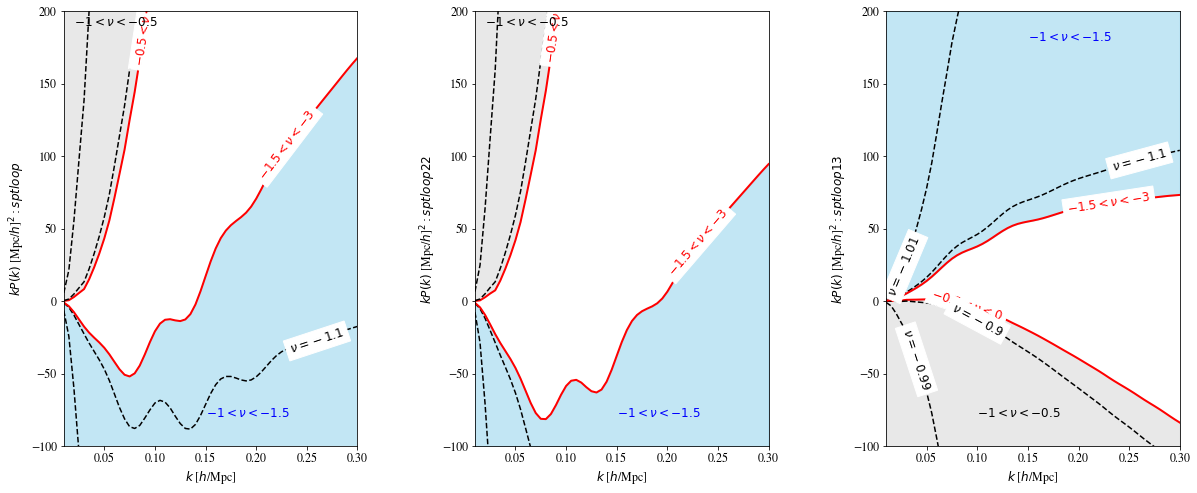

In [834]:
f, ax = plt.subplots(1, 3, figsize=(20,8), sharey=False, sharex=True)
plt.subplots_adjust(wspace=.4, hspace=0)

uv_finite_dm =  uv_finite_p13(1, 1, 0)[0] 

for n, (fftbias, pkm) in enumerate(zip(manyfftbias, manypkm)):
    for i, what in enumerate(pieces[1:]):
        if fftbias == -0.51:
            ax[i].plot(kdata, kdata*pkm[i+1][1], 'r', lw=2, label=r'$-0.5<\nu<0$')
        elif fftbias == -1.49:
            ax[i].plot(kdata, kdata*pkm[i+1][1], 'r', lw=2, label=r'$-1.5<\nu<-3$')
        else:
            ax[i].plot(kdata, kdata*pkm[i+1][1], 'k--', label=r'$\nu = %s$' % (fftbias))
        #ax[0,i].plot(kdata, kdata*(pkm0p3[i][0] + uv_finite_dm), 'k:', label=r'$\nu=-0.3 - k^2 P11$')
        ax[i].set_xlim(0.01, 0.3)
        ax[i].set_ylim(-100, 200)
        ax[i].set_xlabel(r'$k$ [$h$/Mpc]')
        ax[i].set_ylabel(r'$k P(k)$ [Mpc/$h$]$^{2} : %s$' % what)
        
for i, what in enumerate(pieces[1:]):
    labelLines(ax[i].get_lines(), xvals=[0.09, 0.10, 0.04, 0.028, 0.26, 0.23])
    
ax[0].fill_between(kdata, 200., kdata*manypkm[0][1][1], alpha=0.5, color='lightgray')
ax[1].fill_between(kdata, 200., kdata*manypkm[0][2][1], alpha=0.5, color='lightgray')
ax[2].fill_between(kdata, -200., kdata*manypkm[0][3][1], alpha=0.5, color='lightgray')

ax[0].fill_between(kdata, -200., kdata*manypkm[-1][1][1], alpha=0.5, color='skyblue')
ax[1].fill_between(kdata, -200., kdata*manypkm[-1][2][1], alpha=0.5, color='skyblue')
ax[2].fill_between(kdata, 200., kdata*manypkm[-1][3][1], alpha=0.5, color='skyblue')

ax[0].text(0.02, 190, r"$-1<\nu<-0.5$")
ax[0].text(0.15, -80, r"$-1<\nu<-1.5$", color='blue')

ax[1].text(0.02, 190, r"$-1<\nu<-0.5$")
ax[1].text(0.15, -80, r"$-1<\nu<-1.5$", color='blue')

ax[2].text(0.1, -80, r"$-1<\nu<-0.5$")
ax[2].text(0.15, 180, r"$-1<\nu<-1.5$", color='blue')

#ax[0].legend()

### Biased tracers

In [289]:
reload(pybird)
bias = { "b1": 2., "b2": 0.6, "b3": 0.2, "b4": 1.2, "cct": 1.2 }
# bias = { "b1": 2., "b2": 1.2, "b3": 2., "b4": 1.2, "cct": 1.2 }
N = pybird.Correlator()
N.set({'output': 'bPk', 'multipole': 0, 'xdata': kdata, 'resum': False, 
       'keep_loop_pieces_independent': True, 'fftbias': -1.6})
N.compute({'k11': kk, 'P11': pklin})
pkm1p6 = []
for what in pieces: pkm1p6.append( N.get(bias, what=what) )

N = pybird.Correlator()
N.set({'output': 'bPk', 'multipole': 0, 'xdata': kdata, 'resum': False, 
       'keep_loop_pieces_independent': True, 'fftbias': -0.3})
N.compute({'k11': kk, 'P11': pklin})
pkm0p3 = []
for what in pieces: pkm0p3.append( N.get(bias, what=what) )

-1.6
-0.3


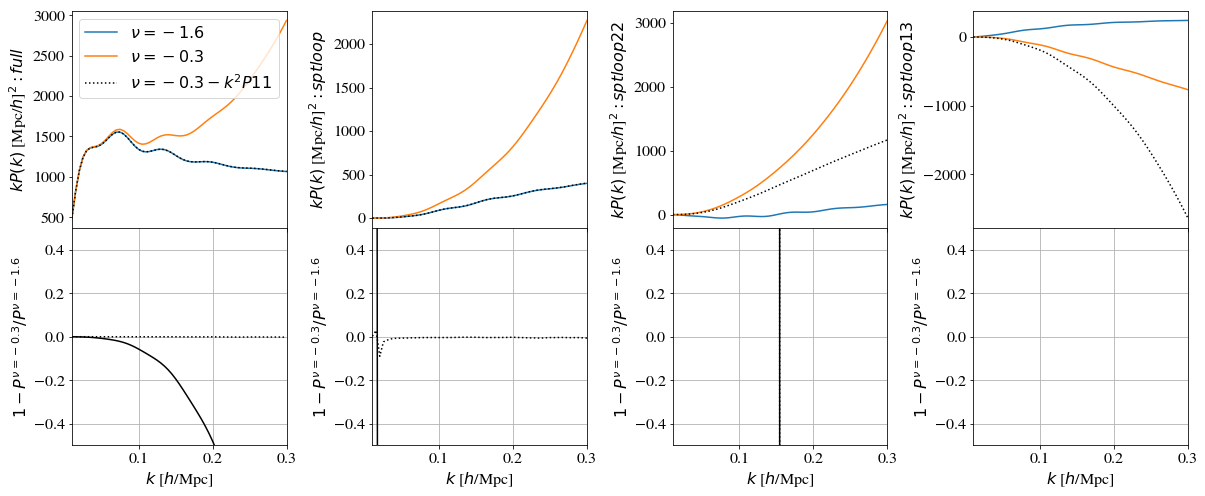

In [290]:
f, ax = plt.subplots(2, 4, figsize=(20,8), sharey=False, sharex=True)
plt.subplots_adjust(wspace=.4, hspace=0)

uv_finite_bp13 = uv_finite_p13(bias["b1"], bias["b3"], 0)[0] - 68004.6 * kdata**2 

for i, what in enumerate(pieces):
    ax[0,i].plot(kdata, kdata*pkm1p6[i][0], label=r'$\nu=-1.6$')
    ax[0,i].plot(kdata, kdata*pkm0p3[i][0], label=r'$\nu=-0.3$')
    ax[0,i].plot(kdata, kdata*(pkm0p3[i][0] + uv_finite_bp13), 'k:', label=r'$\nu=-0.3 - k^2 P11$')
    ax[0,i].set_xlim(0.01, 0.3)
    ax[0,i].set_xlabel(r'$k$ [$h$/Mpc]')
    ax[0,i].set_ylabel(r'$k P(k)$ [Mpc/$h$]$^{2} : %s$' % what)
ax[0,0].legend()

for i, what in enumerate(pieces):
    ax[1,i].plot(kdata, 1-pkm0p3[i][0]/pkm1p6[i][0], 'k')
    ax[1,i].plot(kdata, 1-(pkm0p3[i][0] + uv_finite_bp13)/pkm1p6[i][0], 'k:')
    ax[1,i].set_xlim(0.01, 0.3)
    ax[1,i].set_xlabel(r'$k$ [$h$/Mpc]')
    ax[1,i].set_ylabel(r'$1-P^{\nu=-0.3}/P^{\nu=-1.6}$')
    ax[1,i].set_ylim(-0.5, 0.5)
    ax[1,i].grid()


### Biased tracers in redshift space

In [318]:
bias = { "b1": 2., "b2": 0.6, "b3": 0.2, "b4": 1.2, "cct": 1.2, 'cr1': -1.6, 'cr2': 2. }
N = pybird.Correlator()
N.set({'output': 'bPk', 'multipole': 3, 'xdata': kdata, 'resum': False, 
       'keep_loop_pieces_independent': True, 'fftbias': -1.6})
N.compute({'k11': kk, 'P11': pklin, 'f': f1})
pkm1p6 = []
for what in pieces: pkm1p6.append( N.get(bias, what=what) )

N = pybird.Correlator()
N.set({'output': 'bPk', 'multipole': 3, 'xdata': kdata, 'resum': False, 
       'keep_loop_pieces_independent': True, 'fftbias': -0.3})
N.compute({'k11': kk, 'P11': pklin, 'f': f1})
pkm0p3 = []
for what in pieces: pkm0p3.append( N.get(bias, what=what) )

-1.6
-0.3


monopole

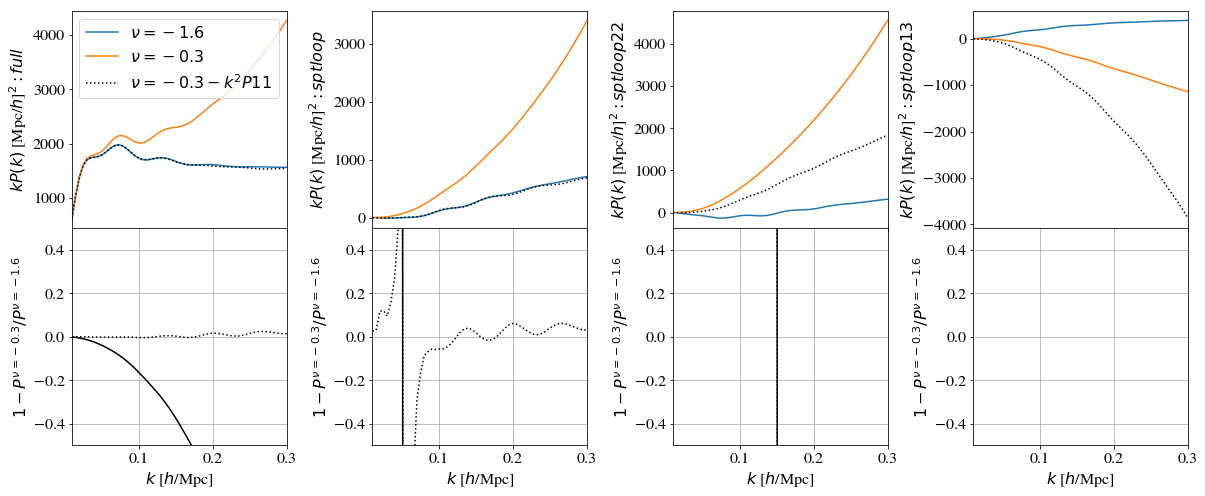

In [319]:
f, ax = plt.subplots(2, 4, figsize=(20,8), sharey=False, sharex=True)
plt.subplots_adjust(wspace=.4, hspace=0)

uv_finite_bp13 = uv_finite_p13(bias["b1"], bias["b3"], f1)[0] - 68004.6 * mu[0][0] *kdata**2 + 2608.48 * mu[2][0] * kdata**2
    
for i, what in enumerate(pieces):
    ax[0,i].plot(kdata, kdata*pkm1p6[i][0], label=r'$\nu=-1.6$')
    ax[0,i].plot(kdata, kdata*pkm0p3[i][0], label=r'$\nu=-0.3$')
    ax[0,i].plot(kdata, kdata*(pkm0p3[i][0] + uv_finite_bp13), 'k:', label=r'$\nu=-0.3 - k^2 P11$')
    ax[0,i].set_xlim(0.01, 0.3)
    ax[0,i].set_xlabel(r'$k$ [$h$/Mpc]')
    ax[0,i].set_ylabel(r'$k P(k)$ [Mpc/$h$]$^{2} : %s$' % what)


    ax[1,i].plot(kdata, 1-pkm0p3[i][0]/pkm1p6[i][0], 'k')
    ax[1,i].plot(kdata, 1-(pkm0p3[i][0] + uv_finite_bp13)/pkm1p6[i][0], 'k:')
    ax[1,i].set_xlim(0.01, 0.3)
    ax[1,i].set_xlabel(r'$k$ [$h$/Mpc]')
    ax[1,i].set_ylabel(r'$1-P^{\nu=-0.3}/P^{\nu=-1.6}$')
    ax[1,i].set_ylim(-0.5, 0.5)
    ax[1,i].grid()
    
ax[0,0].legend()


quadrupole

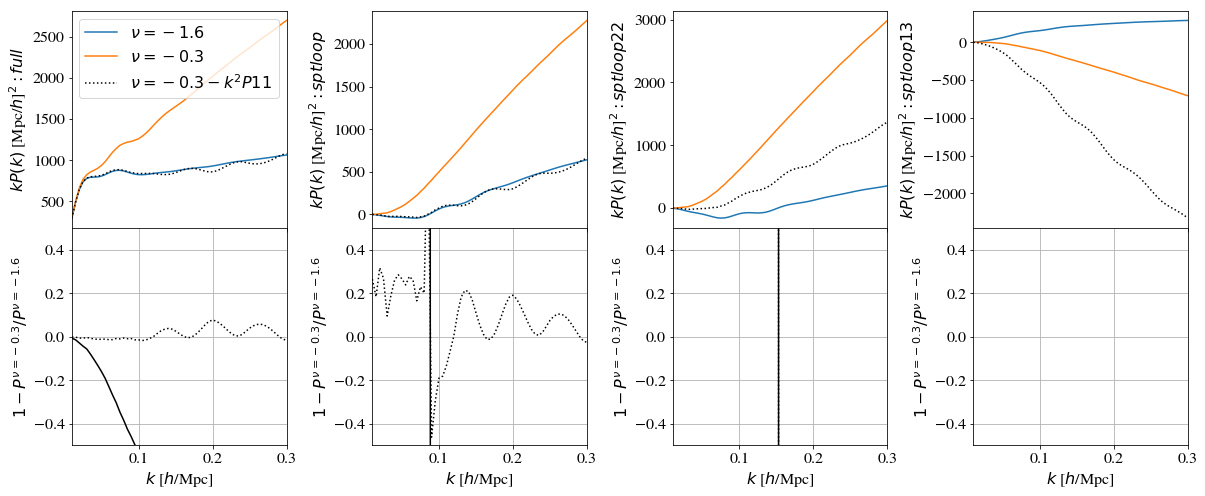

In [331]:
f, ax = plt.subplots(2, 4, figsize=(20,8), sharey=False, sharex=True)
plt.subplots_adjust(wspace=.4, hspace=0)

uv_finite_bpred = uv_finite_p13(bias["b1"], bias["b3"], f1)[1] + 0.4/1e-4 * kdata - 68004.6 * mu[0][2] *kdata**2 + 2608.48 * mu[2][2] * kdata**2
    
for i, what in enumerate(pieces):
    ax[0,i].plot(kdata, kdata*pkm1p6[i][1], label=r'$\nu=-1.6$')
    ax[0,i].plot(kdata, kdata*pkm0p3[i][1], label=r'$\nu=-0.3$')
    ax[0,i].plot(kdata, kdata*(pkm0p3[i][1] + uv_finite_bpred), 'k:', label=r'$\nu=-0.3 - k^2 P11$')
    ax[0,i].set_xlim(0.01, 0.3)
    ax[0,i].set_xlabel(r'$k$ [$h$/Mpc]')
    ax[0,i].set_ylabel(r'$k P(k)$ [Mpc/$h$]$^{2} : %s$' % what)
    
    ax[1,i].plot(kdata, 1-pkm0p3[i][1]/pkm1p6[i][1], 'k')
    ax[1,i].plot(kdata, 1-(pkm0p3[i][1] + uv_finite_bpred)/pkm1p6[i][1], 'k:')
    ax[1,i].set_xlim(0.01, 0.3)
    ax[1,i].set_xlabel(r'$k$ [$h$/Mpc]')
    ax[1,i].set_ylabel(r'$1-P^{\nu=-0.3}/P^{\nu=-1.6}$')
    ax[1,i].set_ylim(-0.5, 0.5)
    ax[1,i].grid()
    
ax[0,0].legend()

hexadecapole

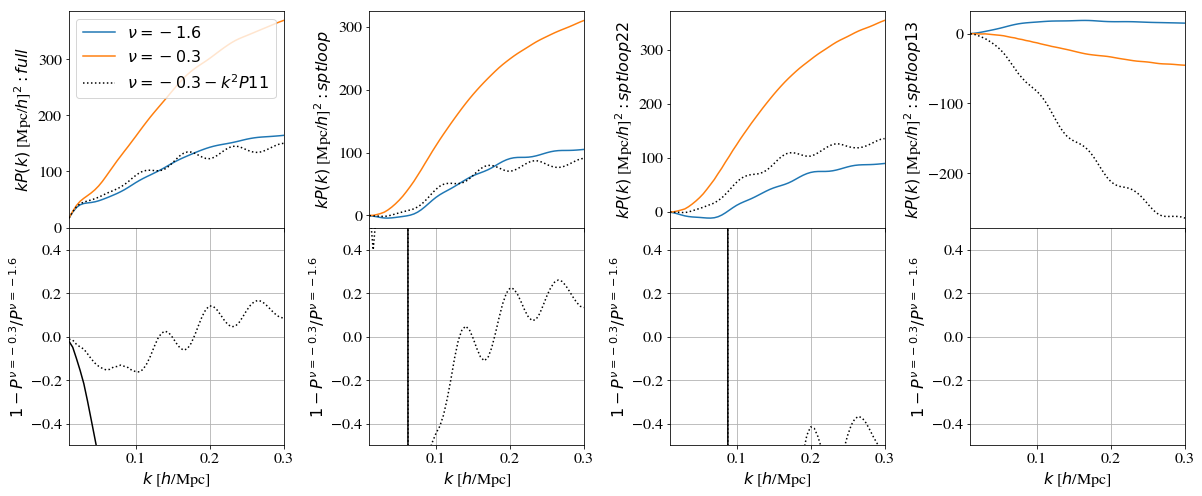

In [335]:
f, ax = plt.subplots(2, 4, figsize=(20,8), sharey=False, sharex=True)
plt.subplots_adjust(wspace=.4, hspace=0)

uv_finite_bpred = uv_finite_p13(bias["b1"], bias["b3"], f1)[2] + 0.18/1e-4 * kdata # - 68004.6 * mu[0][4] *kdata**2 + 2608.48 * mu[2][4] * kdata**2

for i, what in enumerate(pieces):
    ax[0,i].plot(kdata, kdata*pkm1p6[i][2], label=r'$\nu=-1.6$')
    ax[0,i].plot(kdata, kdata*pkm0p3[i][2], label=r'$\nu=-0.3$')
    ax[0,i].plot(kdata, kdata*(pkm0p3[i][2] + uv_finite_bpred), 'k:', label=r'$\nu=-0.3 - k^2 P11$')
    ax[0,i].set_xlim(0.01, 0.3)
    ax[0,i].set_xlabel(r'$k$ [$h$/Mpc]')
    ax[0,i].set_ylabel(r'$k P(k)$ [Mpc/$h$]$^{2} : %s$' % what)
    
    ax[1,i].plot(kdata, 1-pkm0p3[i][2]/pkm1p6[i][2], 'k')
    ax[1,i].plot(kdata, 1-(pkm0p3[i][2] + uv_finite_bpred)/pkm1p6[i][2], 'k:')
    ax[1,i].set_xlim(0.01, 0.3)
    ax[1,i].set_xlabel(r'$k$ [$h$/Mpc]')
    ax[1,i].set_ylabel(r'$1-P^{\nu=-0.3}/P^{\nu=-1.6}$')
    ax[1,i].set_ylim(-0.5, 0.5)
    ax[1,i].grid()
    
ax[0,0].legend()